# random change in erodibility by fire

In [75]:
# here are the new functionalities to implement randomly burned areas....

class ErodibilityStepper:
    """
    This class is initialized by a decay_constant, describing the rate at which
    the erodibility of burned areas recovers, and a baseline erodibility value Ksed0.
    """
    def __init__(self, decay_time=1, K_sed0=1):
        self.decay_time = decay_time
        self.K_sed0 = K_sed0
        
    def stepper(self, space, dt):
        """
        This method takes in  a space object "space",
        an equilibrium (in the absence of burning) erodibility Ksed0,
        and a timestep "space_dt" to modify the erodibility
        of `space` on each gridcell by one timestep by the equation
        dK/dt = -decay_const*(Ksed-Ksed0). 
        Describing a decay of the erodibility toward its equilibrium
        value Ksed_0
        """
        # solve the DE with simple Euler method
        dK_sed =  -(space.K_sed-K_sed0)*dt/self.decay_time # erodibility decay in time
        space.K_sed += dK_sed # modify the erodibility in place
        
class Burner:
    """
    This is initialized by a fire frequency, mean fire radius in units of the grid size,
    and the amount K_sed_boost by which the sediment erodibility is increased by fire.
    The method `fire` modifies (in place) the erodibility of nodes where the fire occurred.
    """
    def __init__(self, fire_freq=1, R_fire=1, K_sed_boost=1, dt = 1):
        """
        fire frequency -- how often fires occur [1/T]
        fire radius -- typical size of fires [L]
        K_sed_boost -- amount by which K_sed is increased by fire
        dt -- space model timestep.
        """
        self.fire_freq = fire_freq # average number of fires per unit time
        self.R_fire = R_fire # the radius of the fire... 
        self.K_sed_boost = K_sed_boost # the amount by which the sediment erodibility is increased by fire
        self.dt = dt # the timestep on which to evaluate the probability that a fire occurs
        
    def fire(self, space, grid):
        """
        Generates a fire at a random location within the grid.
        First calculates whether or not a fire occurs at the timestep.
        Then 
        """
        # fire occurs if..
        #    a random exceeds the probability that fire does not occur
        occurs = np.exp(-self.dt*self.fire_freq) < np.random.random() # prob fire does not occur < random 
        if not occurs: # if fire does not occur...
            pass # do nothing. This comes first as it's the most common scenario.
        else: # if fire does occur
            K_sed = space.K_sed # get the array of sediment erodibilities before the fire
            # find the coordinates of this erodibility array which are to be changed
            center = np.random.choice(K_sed.size) # select a random node for the fire center
            # locate all nodes within R_fire of the center node.
            changed_nodes = self._within(center, self.R_fire, space, grid) # based on Laurent's code.
            # modify those nodes only.. they should increase erodibility !
            K_sed[changed_nodes]+= self.K_sed_boost # increase them by K_sed_boost
            # set these into the space object as the new erodibility
            space.K_sed = K_sed # modify in place. Erodibility is now boosted by the fire.
            # This occurs on all cells within proximity R_fire of the fire center
        
    def _within(self,center, R_fire, space, grid):
        """
        return all nodes within distance R_fire of center within grid. Utility function.
        Takes:
            center -- a single index (i.e. '3') into the 1D array of nodes
            R_fire -- the radius of a fire in gridsize units
            space -- the SPACE object (called ha..)
            grid -- the RasterModelGrid object (called mg ..)
        """
        centerPoint = (grid.x_of_node[center], grid.y_of_node[center]) # the center of the fire
        mask = grid.calc_distances_of_nodes_to_point(centerPoint) < R_fire # mask of nodes in radius
        # all nodes within R_fire of the centerPoint
        return np.arange(mask.size)[mask] # return indices of all nodes within distance R_fire

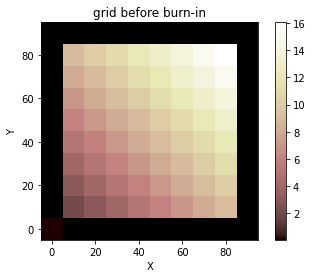

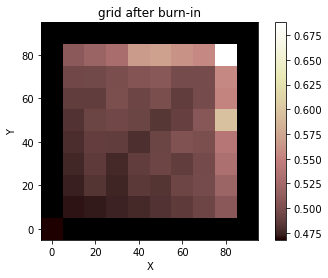

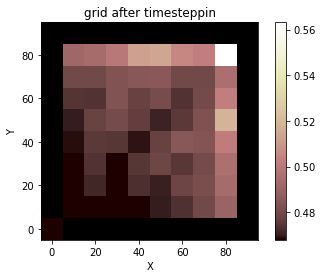

In [72]:
import numpy as np
import matplotlib.pyplot as plt 
from landlab.components import (DepressionFinderAndRouter,
                                FastscapeEroder,
                                FlowAccumulator,
                                Space)
from landlab import (RasterModelGrid,
                     imshow_grid)
%matplotlib inline


# 5x5 grid with baselevel in lower left corner
# all other boundary nodes closed
# init topography is plane tilted up to the upper right with noise

mg = RasterModelGrid((10, 10), xy_spacing=10.0)
_ = mg.add_zeros('topographic__elevation', at='node')
mg.at_node['topographic__elevation'] += (mg.node_y / 10. + 
                                         mg.node_x / 10. + np.random.rand(len(mg.node_y)) / 10.)
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                        left_is_closed=True,
                                        right_is_closed=True,
                                        top_is_closed=True)
mg.set_watershed_boundary_condition_outlet_id(
     0, mg.at_node['topographic__elevation'], -9999.)
fsc_dt = 100. # timestep for fastcape eroder
space_dt = 100. # timestep for space

# show the pre-burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid before burn-in')
plt.show()

#Instantiate Fastscape eroder, flow router, and depression finder
fr = FlowAccumulator(mg, flow_director='D8')
df = DepressionFinderAndRouter(mg)
fsc = FastscapeEroder(
    mg,
    K_sp=.001,
    m_sp=.5,
    n_sp=1)

# burn in an initial drainage ntework using the fastscape eroder
for x in range(100):
    fr.run_one_step()
    df.map_depressions()
    fsc.run_one_step(dt=fsc_dt)
    mg.at_node['topographic__elevation'][0] -= 0.001 # Uplift
    
# add soil to the drainage network
_ = mg.add_zeros('soil__depth', at='node', dtype=float) 
mg.at_node['soil__depth'] += 0.5
mg.at_node['topographic__elevation'] += mg.at_node['soil__depth']


# plot after burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid after burn-in')
plt.show()


# init the space component
K_sed0 = 0.00001 # the baseline soil erodiblity
K_sed = np.ones(mg.shape)*Ksed0*10 # the initial soil erodibility per node NOTICE started high...
ha = Space(
    mg,
    K_sed=K_sed,
    K_br=0.00000000001,
    F_f=0.5,
    phi=0.1,
    H_star=1.,
    v_s=0.001,
    m_sp=0.5,
    n_sp = 1.0,
    sp_crit_sed=0,
    sp_crit_br=0)


# init the erodibility stepper
decay_time = 10*space_dt # inverse time it takes the erodibility perturbution to decay
es = ErodibilityStepper(decay_time=decay_time, K_sed0=K_sed0)
# this leads to decay in the erodibility from whatever value it's at.

# init the burner
burner = Burner(fire_freq=1/space_dt,
                R_fire=30.0,
                K_sed_boost=10*K_sed0,
                dt=dt_space)


# run Space component for 2000 short timesteps:
for x in range(2000): #Space component loop
    fr.run_one_step()
    df.map_depressions()
    ha.run_one_step(dt=space_dt)
    es.stepper(ha,dt=space_dt) # decay the erodibility from the former timestep
    burner.fire(ha,mg)
    mg.at_node['bedrock__elevation'][0] -= 2e-6 * space_dt
        
# plot after iteration grid
mg.imshow('node','topographic__elevation')
plt.title('grid after timesteppin')
plt.show()